# Contents

### I have designed this notebook to forecast Apple Stock's closing  price
### Creating a time series out of a data frame
### Usage of the pd.resample(), to smoothen time series
### Testing if the time series is stationary using Argumented Dicky fuller test
### Using ACF and PACF to check the lag wise correlations (pacf for direct correlation)
### Building the ARIMA model, with pdq derived from auto arima
### Visualizing the model performance
### Feature scaling and Data preprocessing for the LSTM model
### Building the LSTM model using Tensorflow
### Drastically improving the performance by using an LSTM model
### Visualizing the forecasts for the next 30 time steps (Next 30 days of closing price)

# Data Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import files

In [4]:
data = pd.read_csv('appl.csv')

In [5]:
data.drop('Unnamed: 0', axis = 1, inplace = True)

In [6]:
data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


# Checking Temporal Granularity of the data/ Data Preprocessing

In [7]:
data['date'] = pd.to_datetime(data['date'])

In [8]:
ts_df = data.set_index(data['date'])['close']

In [9]:
print("The type of the series is date column is ", data['date'].dtypes)

The type of the series is date column is  datetime64[ns, UTC]


In [10]:
ts_df.name = 'Apple_Stock_price' # The data is in daily granulaity
ts_df.head()

date
2015-05-27 00:00:00+00:00    132.045
2015-05-28 00:00:00+00:00    131.780
2015-05-29 00:00:00+00:00    130.280
2015-06-01 00:00:00+00:00    130.535
2015-06-02 00:00:00+00:00    129.960
Name: Apple_Stock_price, dtype: float64

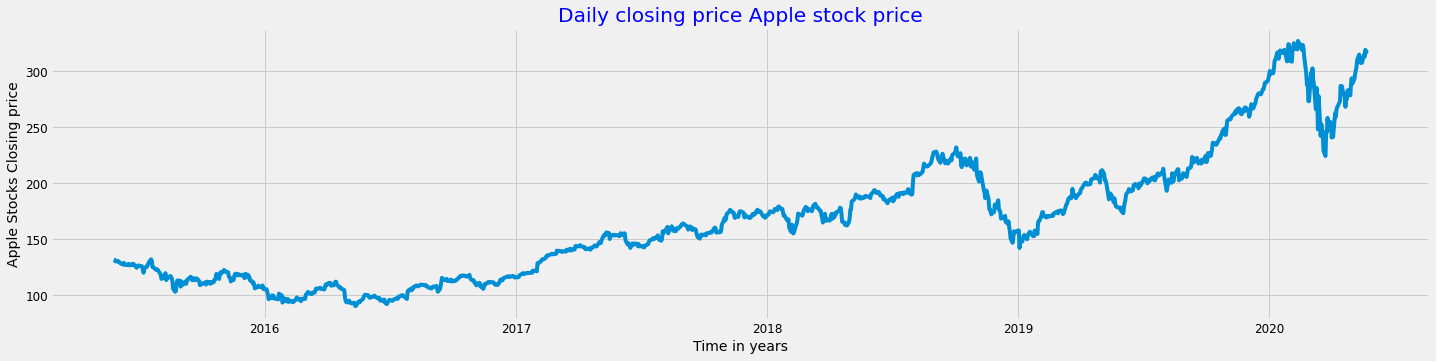

In [41]:
# Let's viuslaize the time series and check for it trend, seasonality and it's variablity with respect to time
import matplotlib.pyplot as plt

import matplotlib

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'b'


#import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(22,5))
plt.plot(ts_df)
plt.title('Daily closing price Apple stock price')
plt.xlabel("Time in years")
plt.ylabel("Apple Stocks Closing price")
plt.show()

### Inference : There is a positive trend with respect to time, The seasonality of this time series is demurable. Let me try smoothing the time series and see if I can pick up something visually.

In [42]:
# Smoothing: By timely granularity : Weekly >Months

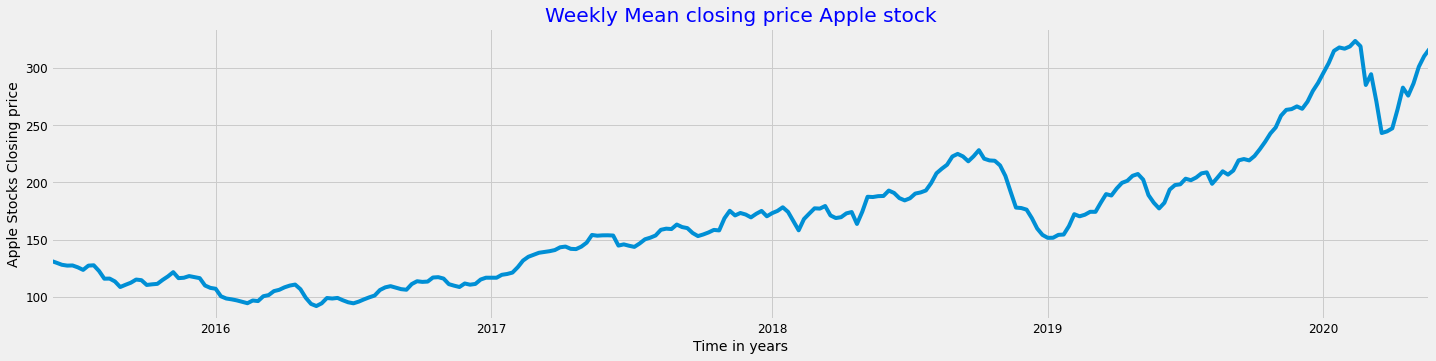

In [43]:
plt.figure(figsize=(22,5))
plt.title('Weekly Mean closing price Apple stock')
ts_df.resample('w').mean().plot()
plt.xlabel("Time in years")
plt.ylabel("Apple Stocks Closing price")
plt.show()

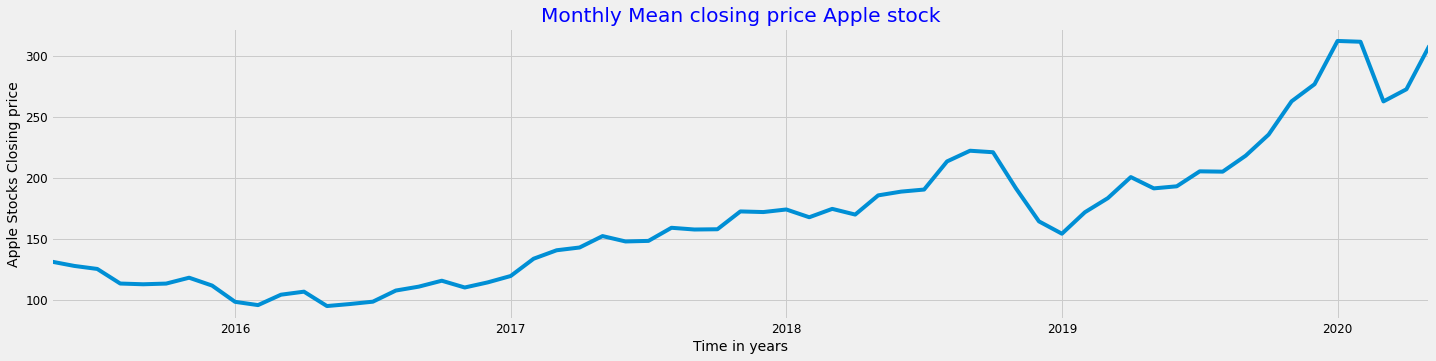

In [44]:
plt.figure(figsize=(22,5))
plt.title('Monthly Mean closing price Apple stock')
ts_df.resample('M').mean().plot()
plt.xlabel("Time in years")
plt.ylabel("Apple Stocks Closing price")
plt.show()

### The time series seems to be non-stationary. I am running the Argumented Dicky Fuller Test to check if the time series is statioarity or not. 

In [45]:
# Test for seasonality
def stationary_checker(df,x):
    from statsmodels.tsa.stattools import adfuller
    
    # Rolling Statistics test
    rolling_mean = df.rolling(window = 12).mean()
    rolling_std =  df.rolling(window = 12).std()
    
    print('Rolling Statistics Test')
    plt.figure(figsize=(22,5))
    original = plt.plot(df,color = 'blue', label = 'Original')
    rol_mean = plt.plot(rolling_mean, color = 'red', label = 'Rolling_mean')
    rol_std = plt.plot(rolling_std, color = 'green', label = 'Rolling_std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Rolling Std')
    plt.show()
    
    print('Argumented Dicky Fuller Test')
    # ADF Test
    result = adfuller(x, autolag='AIC')
    print('ADF Statistic:', result[0])
    print(f'p-value:', result[1])
    for key, value in result[4].items():
        print('Critial Values:')
        print( key, value)


Rolling Statistics Test


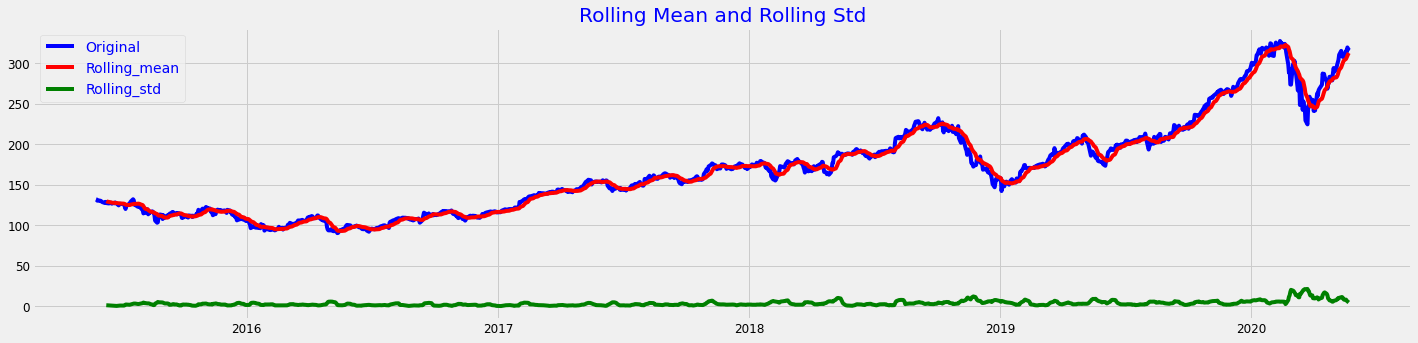

Argumented Dicky Fuller Test
ADF Statistic: -0.10012966467734657
p-value: 0.9494256168598443
Critial Values:
1% -3.435638861796935
Critial Values:
5% -2.863875547501718
Critial Values:
10% -2.5680134763122906


In [46]:
import warnings
warnings.filterwarnings('ignore')
stationary_checker(ts_df, ts_df.values)

In [47]:
# We can see that rolling mean and the rolling std varry with respect to time, 
# The the time series still shows a trend 
# The p-value of the argumented dickly fuller test is greater than 0.9.
# Thus, This time series is non-stationarty


In [48]:
# Trying to make the series Stationarity, by differencing it by 1 period

ts_df_1_diff = ts_df.diff(periods= 1)
ts_df_1_diff.head()

date
2015-05-27 00:00:00+00:00      NaN
2015-05-28 00:00:00+00:00   -0.265
2015-05-29 00:00:00+00:00   -1.500
2015-06-01 00:00:00+00:00    0.255
2015-06-02 00:00:00+00:00   -0.575
Name: Apple_Stock_price, dtype: float64

Rolling Statistics Test


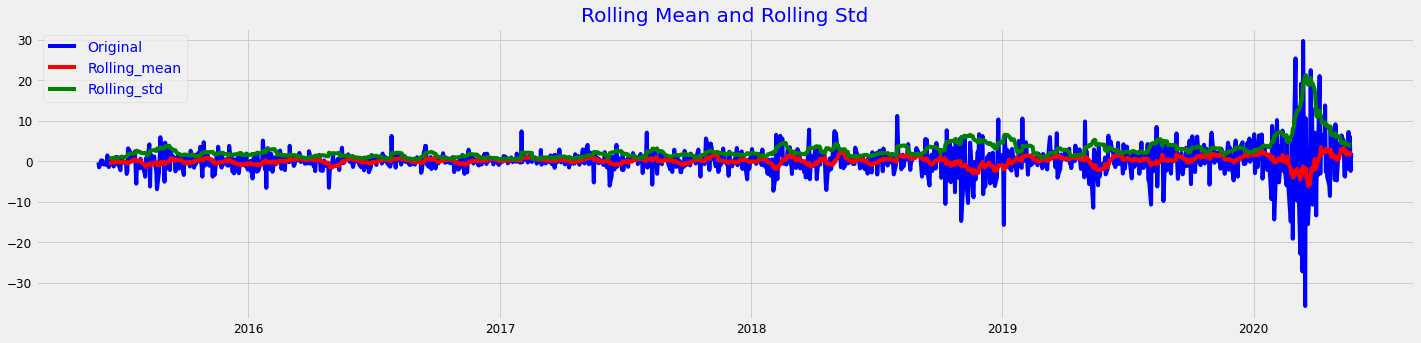

Argumented Dicky Fuller Test
ADF Statistic: -6.239529846021834
p-value: 4.73444892866212e-08
Critial Values:
1% -3.435638861796935
Critial Values:
5% -2.863875547501718
Critial Values:
10% -2.5680134763122906


In [49]:
import warnings
warnings.filterwarnings('ignore')
ts_df_1_diff.dropna(inplace= True)
stationary_checker(ts_df_1_diff, ts_df_1_diff.values)

In [50]:
# From the argumented dicky fuller test results we can say our data is now stationary
# Let's build the ACF and PACF on the differnced data, to infer the direct and indirect effects of the lags give time S(t)

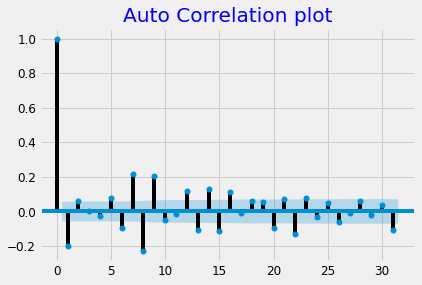

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_df_1_diff.dropna(), title = 'Auto Correlation plot');

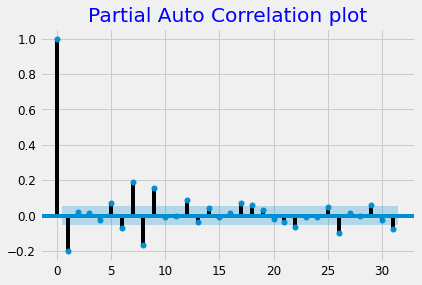

In [52]:
plot_pacf(ts_df_1_diff.dropna(), title= 'Partial Auto Correlation plot');

### Inferences : 
The lags are showing no better correlation that -0.2 or 0.2 units. 


---



Which is very less correlation.



---

---





Since the time series has a trend component, build an AR, MA or an ARMA model is not an ideal option, because they expect these expect the mean and the std to be a constant. Thus building an ARIMA model. with the acquired orders p =1, d = 1, q =1 (1,1,1)

### Train Test Split

In [23]:
train = ts_df[0:944]
test = ts_df[945:]

Autoarima is a grid search mechanism, used to find the optimal pdq values

In [24]:
pip install -U pmdarima

Requirement already up-to-date: pmdarima in /usr/local/lib/python3.6/dist-packages (1.8.0)


In [55]:
from pmdarima import auto_arima
auto_arima(ts_df,seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1258
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -3345.465
Date:                Sun, 07 Feb 2021   AIC                           6702.930
Time:                        12:27:55   BIC                           6733.749
Sample:                             0   HQIC                          6714.513
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5494      0.346      1.586      0.113      -0.129       1.228
ar.L1         -1.7669      0.012   -141.720      0.000      -1.791      -1.742
ar.L2         -0.9208      0.012    -75.036      0.000      -0.945      -0.897
ma.L1          1.6697      0.017     95.747      0.000       1.636       1.704
ma.L2          0.7948      0.017     47.388      0.000       0.762       0.828
sigma2        11.9958      0.189     63.309      0.000      11.624      12.367
===================================================================================
Ljung-Box (L1) (Q):                   0.78   Jarque-Bera (JB):              9403.29
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               9.49   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Using the optimal values to build the arima model

In [56]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults

In [57]:
model = ARIMA(train,order=(2,1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                              
===============================================================================
Dep. Variable:     D.Apple_Stock_price   No. Observations:                  943
Model:                  ARIMA(2, 1, 2)   Log Likelihood               -2145.791
Method:                        css-mle   S.D. of innovations              2.349
Date:                 Sun, 07 Feb 2021   AIC                           4303.582
Time:                         12:29:15   BIC                           4332.676
Sample:                              1   HQIC                          4314.671
                                                                               
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0451      0.078      0.581      0.561      -0.107       0.197
ar.L1.D.Apple_Stock_price     0.7354      0.004    171.242      0.000       0.727       0.744
ar.L2.D.Apple_Stock_price    -0.9938      0.004   -248.416      0.000      -1.002      -0.986
ma.L1.D.Apple_Stock_price    -0.7243      0.003   -208.726      0.000      -0.731      -0.718
ma.L2.D.Apple_Stock_price     1.0000      0.005    194.523      0.000       0.990       1.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3700           -0.9324j            1.0031           -0.1899
AR.2            0.3700           +0.9324j            1.0031            0.1899
MA.1            0.3622           -0.9321j            1.0000           -0.1910
MA.2            0.3622           +0.9321j            1.0000            0.1910
-----------------------------------------------------------------------------
"""

In [58]:
start = len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')
predictions_train = results.predict(start=2, end=len(train), dynamic=False, typ='levels')

In [59]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test, predictions))

72.21523039693777

In [60]:
# plot baseline and prediction
train_plot = np.empty_like(ts_df)
train_plot[0:len(predictions_train)] = predictions_train
train_plot[len(predictions_train):len(ts_df)] = np.nan
train_plot = pd.Series(train_plot)
train_plot.index = ts_df.index

test_plot = np.empty_like(ts_df)
test_plot[0:len(predictions_train)] = np.nan
test_plot[len(predictions_train)+2:len(ts_df)] = predictions
test_plot = pd.Series(test_plot)
test_plot.index = ts_df.index


In [61]:
test_plot.drop(test_plot[test_plot<1].index, inplace = True)

No handles with labels found to put in legend.


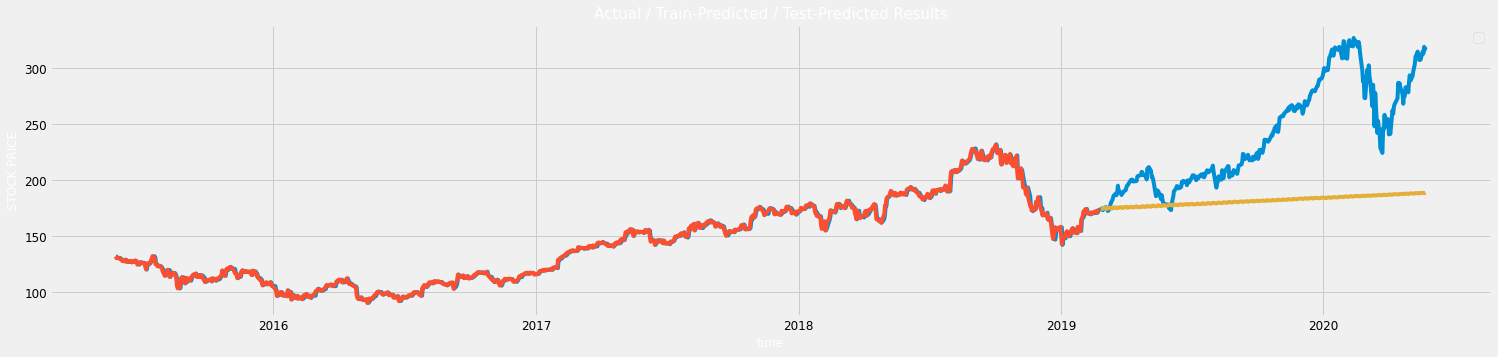

In [64]:

plt.figure(figsize = (23,5))
plt.plot(ts_df)
plt.plot(train_plot)
plt.plot(test_plot[3:])
plt.title("Actual / Train-Predicted / Test-Predicted Results", color = 'white', fontsize = 15)
plt.xlabel("time", color = 'white', fontsize = 12)
plt.ylabel("STOCK PRICE", color = 'white', fontsize = 12)
plt.legend(loc = True)
plt.show()

In [65]:
print("Mean of the times series",ts_df.mean())

167.72399841017477

In [166]:
print("Standard deviation of the time series",ts_df.std())

Standard deviation of the time series 56.85079637576296


With acquired mean and standard deviation of the data, we can see the RMSE of 72 is very bad.


# Trying to build an LSTM model

In [ ]:
# Data Preprocessing for the LSTM model

In [67]:
df2 = data.reset_index()['close']

In [68]:
df2.head()

0    132.045
1    131.780
2    130.280
3    130.535
4    129.960
Name: close, dtype: float64

In [69]:
# LSTMs are sensitive to the scale of the data so we need to scale the data
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range = (0,1))
df1 = min_max_scaler.fit_transform(np.array(df2).reshape(-1,1))

In [70]:
df1

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])

In [71]:
# Train Test Split

In [167]:
train_size = int(len(df1)*0.65)
test_size = len(df1)-train_size
train_data, test_data = df1[:train_size] , df1[train_size:]

In [73]:
(train_size, test_size)

(817, 441)

In [74]:
# Create the dataset for the Lstm mode
def create_model(dataset, timestep):
  dataX, dataY = [], []
  for i in range(len(dataset) - timestep -1):
    a = dataset[i:(i+timestep), 0]
    dataX.append(a)
    dataY.append(dataset[i+timestep,0])
  return np.array(dataX), np.array(dataY)

In [75]:
X_train, y_train = create_model(train_data, 100)

In [76]:
X_test, y_test = create_model(test_data, 100)

In [77]:
for i in [X_train, y_train, X_test, y_test]:
  print(i.shape)

(716, 100)
(716,)
(340, 100)
(340,)


In [78]:
# Creating the stack LSTM

In [79]:
# LSTM models can only accept the data in a selective format, reshaping the data to create it.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [80]:
# Invoking the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [81]:
model = Sequential()
model.add(LSTM(100, return_sequences= True, input_shape = (100,1))) # Input layer
model.add(LSTM(100, return_sequences= True))
model.add(LSTM(100, return_sequences= True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 231,851
Trainable params: 231,851
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs= 100, batch_size= 100)

Epoch 1/100
8/8 [==============================] - 13s 920ms/step - loss: 0.0335 - val_loss: 0.1030
Epoch 2/100
8/8 [==============================] - 6s 695ms/step - loss: 0.0062 - val_loss: 0.0107
Epoch 3/100
8/8 [==============================] - 5s 687ms/step - loss: 0.0019 - val_loss: 0.0054
Epoch 4/100
8/8 [==============================] - 5s 683ms/step - loss: 0.0013 - val_loss: 0.0073
Epoch 5/100
8/8 [==============================] - 5s 683ms/step - loss: 8.2729e-04 - val_loss: 0.0095
Epoch 6/100
8/8 [==============================] - 5s 685ms/step - loss: 8.0126e-04 - val_loss: 0.0061
Epoch 7/100
8/8 [==============================] - 5s 683ms/step - loss: 7.9435e-04 - val_loss: 0.0047
Epoch 8/100
8/8 [==============================] - 5s 690ms/step - loss: 7.4428e-04 - val_loss: 0.0068
Epoch 9/100
8/8 [==============================] - 5s 687ms/step - loss: 7.9063e-04 - val_loss: 0.0092
Epoch 10/100
8/8 [==============================] - 5s 685ms/step - loss: 8.1991e-04 - v

In [110]:
# Let's predict using this model
y_tarin_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [111]:
# Inverse Transormation 
y_tarin_pred = min_max_scaler.inverse_transform(y_tarin_pred)
y_test_pred = min_max_scaler.inverse_transform(y_test_pred)


In [112]:
# Evaluating the model performance
import math
from sklearn.metrics import mean_squared_error
print("Train RMSE ",math.sqrt(mean_squared_error(min_max_scaler.inverse_transform(y_train.reshape(1,-1))[0], y_tarin_pred)))
print("Test RMSE ",math.sqrt(mean_squared_error(min_max_scaler.inverse_transform(y_test.reshape(1,-1))[0], y_test_pred)))

Train RMSE  4.078401645951871
Test RMSE  11.436641492173445


In [113]:
# Plotting train and test data
# shift trian predictions timestep =100
look_back = 100
trainpredictplot = np.empty_like(df1)
trainpredictplot[:,:] = np.nan
trainpredictplot[look_back:len(y_tarin_pred)+look_back,:] = y_tarin_pred

In [114]:
# shifting test predictions timestamp = 100
testpredictplot = np.empty_like(df1)
testpredictplot[:,:] =  np.nan
testpredictplot[len(y_tarin_pred)+(look_back*2)+1: len(df1)-1, :] = y_test_pred

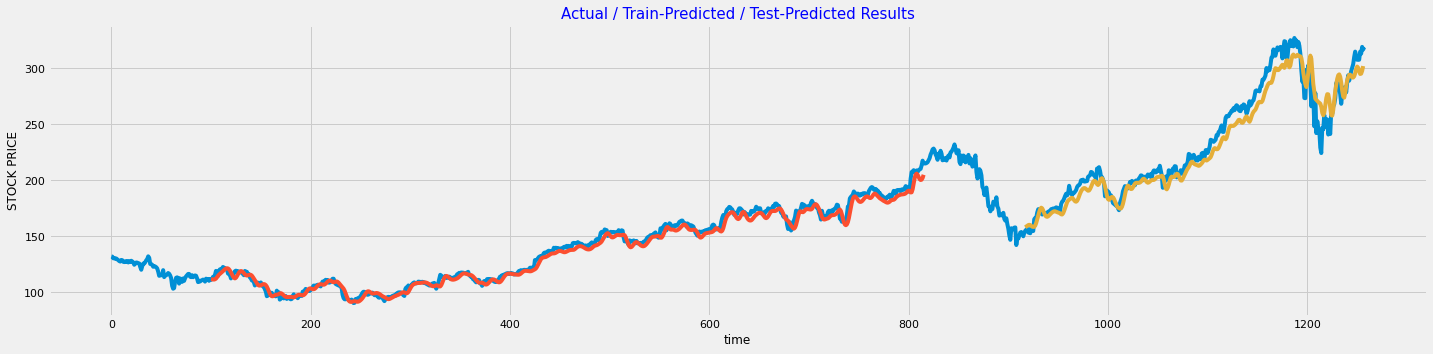

In [115]:
# plot baseline and prediction
plt.figure(figsize = (22,5))
plt.plot(min_max_scaler.inverse_transform(df1))
plt.plot(trainpredictplot)
plt.plot(testpredictplot)
plt.title("Actual / Train-Predicted / Test-Predicted Results", fontsize = 15)
plt.xlabel("time", fontsize = 12)
plt.ylabel("STOCK PRICE", fontsize = 12)
plt.xticks(  fontsize = 11)
plt.yticks( fontsize = 11)
plt.show()

# Forecasting suignt he LSTM-RNN model

In [116]:
x_inputs = test_data[341:].reshape(1,-1)

In [117]:
temp_inputs = x_inputs[0].tolist()

In [118]:
l_op = []
n_steps = 100
i = 0
while(i< 30):
  if (len(temp_inputs) > 100):
    x_input = np.array(temp_inputs[1:])
    # reshaping
    x_input = x_input.reshape((1, n_steps, 1))
    y_hat = model.predict(x_input , verbose = 0)
    temp_inputs.extend(y_hat[0].tolist())
    temp_inputs = temp_inputs[1:]
    # output
    l_op.extend(y_hat[0].tolist())
    i+=1
  else:
    x_input = x_inputs.reshape((1, n_steps, 1))
    # Prediction
    y_hat = model.predict(x_input, verbose= 0)
    temp_inputs.extend(y_hat[0].tolist())
    l_op.extend(y_hat[0].tolist())
    i+=1

print(l_op)

[0.9166141748428345, 0.9057552814483643, 0.8816899061203003, 0.8541495203971863, 0.8298461437225342, 0.8118902444839478, 0.8012333512306213, 0.7976670265197754, 0.8002023100852966, 0.8072406053543091, 0.816797137260437, 0.8267647624015808, 0.8352224230766296, 0.8407156467437744, 0.8424689173698425, 0.8404809832572937, 0.835494875907898, 0.8288265466690063, 0.822094738483429, 0.8168976902961731, 0.8145468235015869, 0.8158585429191589, 0.8210594058036804, 0.8297808766365051, 0.8411519527435303, 0.8539441227912903, 0.8667444586753845, 0.8781660199165344, 0.8870484232902527, 0.892643392086029]


In [154]:
last_100_ips = min_max_scaler.inverse_transform(x_inputs).reshape((1,-1))
forecasts = min_max_scaler.inverse_transform(np.array(l_op).reshape((1,-1)))

In [155]:
final_forecasts = np.empty_like(df1).reshape((1,-1))
final_forecasts[:,:] = np.nan

In [156]:
final_forecasts = np.concatenate([final_forecasts, forecasts], axis = 1)

In [ ]:
final_forecasts = pd.Series(final_forecasts[0])
final_forecasts.index = ts_df.index.tolist()+pd.date_range(pd.to_datetime('2020-05-22  00:00:00+00:00'), periods= 30).tolist()
plt.plot(final_forecasts)

Visualizing the forecasts of the LSTM model

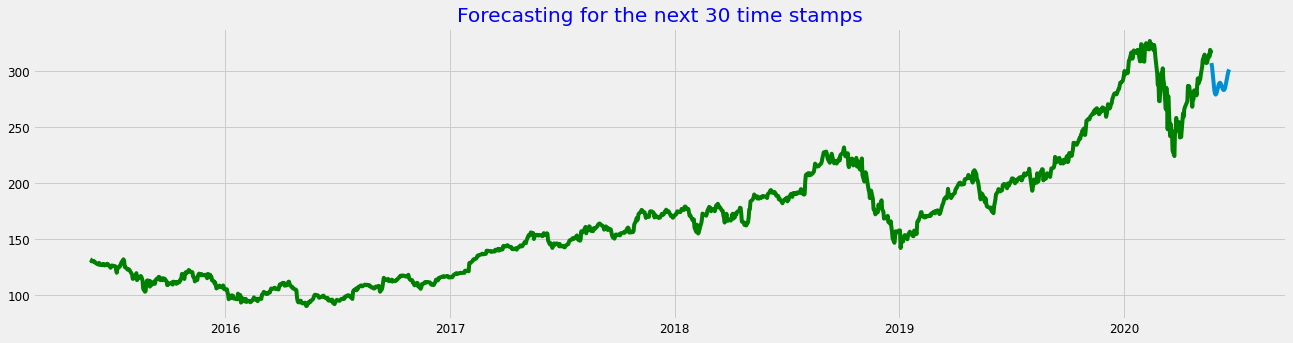

In [165]:
plt.figure(figsize = (20,5))
plt.title("Forecasting for the next 30 time stamps")
plt.plot(ts_df, color = 'g')
plt.plot(final_forecasts)
plt.show()

In [168]:
# The RMSE of the LSTM model is just 13, 56 being the Standard deviation and 167 being the Mean of the data. 
# 13 is a pretty good number on this scale.
# So i have used the LSTM model to forecast the last 30 days